In [1]:
%load_ext watermark
%watermark

Last updated: 2023-08-14T13:32:41.895108-06:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.2

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 6.2.0-27-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 6
Architecture: 64bit



En esta sección vamos a ver diversas formas para procesar un dataset. Por procesamiento (tambien llamado limpieza) nos referimos a preparar el dataset para la creación de modelos predictivos.

#### Descripción

Vamos a usar el mismo dataset que usamos para el ejemplo de Análisis Exploratorio de Datos.

El dataset consiste en información relativa a vehículos vendidos en USA desde 1985. Dicha información incluye detalles técnicos (cilindrada, tipo de transmisión) y detalles medioambientales (consumo de gasolina, emisiones de CO2)

El archivo original está en: https://www.fueleconomy.gov/feg/epadata/vehicles.csv.zip
El archivo que vamos a usar es una versión modificada (con menos columnas)

Descripcion del dataset Original
http://www.fueleconomy.gov/feg/ws/index.shtml#ft7

En la sección de análisis de datos, detectamos los siguientes errores en el dataset original

- Hay 1506 records duplicados
- Las variables desplazamiento, cilindros, transmision y traccion tienen valores inexistentes
- hay un outlier en las variables `co2` y `consumo`
- Hay coches hibridos y coches electricos (hemos removido estos ultimos ya que no contaminan).
- Ninguna variable numérica sigue una distribución normal

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,12)

In [3]:
vehiculos = (pd
             .read_csv("../data/vehiculos_original.csv")
             .rename(columns={
                "cylinders":"cilindros",
                "trany":"transmision",
                "make":"fabricante",
                "model":"modelo",
                "displ":"desplazamiento", #volumen de desplazamiento del motor
                "drive":"traccion",
                "VClass":"clase",
                "fuelType":"combustible",
                "comb08":"consumo", #combined MPG for fuelType1
                "co2TailpipeGpm":"co2", # tailpipe CO2 in grams/mile
            })
            .query("co2>0")
)

In [4]:
vehiculos.shape

(38297, 11)

### Records duplicados

Usamos la función de pandas `drop_duplicates` para remover los records duplicados

In [5]:
vehiculos = vehiculos.drop_duplicates()

In [6]:
vehiculos.shape

(36791, 11)

### Valores Extremos (outliers)

In [9]:
from scipy import stats
import numpy as np

def outliers_col(df):
    for columna in df:
        np.object = object    
        if df[columna].dtype != np.object:
            n_outliers = len(df[np.abs(stats.zscore(df[columna])) > 3])    
            print("{} | {} | {}".format(
                df[columna].name,
                n_outliers,
                df[columna].dtype
        ))

outliers_col(vehiculos)

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 400 | int64
co2 | 221 | float64


In [8]:
vehiculos.describe()

,year,desplazamiento,cilindros,consumo,co2
count,36791.000000,36789.000000,36788.000000,36791.000000,36791.000000
mean,2000.787421,3.321786,5.746493,20.012068,473.185008
std,10.374662,1.359945,1.758009,5.109608,118.833905
min,1984.000000,0.600000,2.000000,7.000000,29.000000
25%,1991.000000,2.200000,4.000000,17.000000,386.391304
50%,2002.000000,3.000000,6.000000,19.000000,466.000000
75%,2010.000000,4.300000,6.000000,23.000000,555.437500
max,2018.000000,8.400000,16.000000,58.000000,1269.571429


In [10]:
consumo_min = vehiculos.consumo.mean() - 3*vehiculos.consumo.std()
consumo_max = vehiculos.consumo.mean() + 3*vehiculos.consumo.std()
print(consumo_min, consumo_max)

co2_min = vehiculos.co2.mean() - 3*vehiculos.co2.std()
co2_max = vehiculos.co2.mean() + 3*vehiculos.co2.std()
print(co2_min, co2_max)

4.6832452329136025 35.34089110477768
116.68329326822334 829.6867227314084


In [10]:
vehiculos = vehiculos[
    (np.abs(stats.zscore(vehiculos.consumo)) < 3)  & \
    (np.abs(stats.zscore(vehiculos.co2)) < 3)
]

In [11]:
vehiculos.shape

(36791, 11)

In [12]:
vehiculos.describe()

,year,desplazamiento,cilindros,consumo,co2
count,36791.000000,36789.000000,36788.000000,36791.000000,36791.000000
mean,2000.787421,3.321786,5.746493,20.012068,473.185008
std,10.374662,1.359945,1.758009,5.109608,118.833905
min,1984.000000,0.600000,2.000000,7.000000,29.000000
25%,1991.000000,2.200000,4.000000,17.000000,386.391304
50%,2002.000000,3.000000,6.000000,19.000000,466.000000
75%,2010.000000,4.300000,6.000000,23.000000,555.437500
max,2018.000000,8.400000,16.000000,58.000000,1269.571429


Vemos que aunque hemos removido los outliers, al haber cambiado la distribución del dataset se generan nuevos outliers

In [13]:
outliers_col(vehiculos)

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 400 | int64
co2 | 221 | float64


Para eliminar esto simplemente repetimos el proceso hasta que no queden valores extremos

In [15]:
vehiculos = vehiculos[
    (np.abs(stats.zscore(vehiculos.consumo)) < 3)  & \
    (np.abs(stats.zscore(vehiculos.co2)) < 3)
]

outliers_col(vehiculos)
vehiculos.shape

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 0 | int64
co2 | 9 | float64


(35548, 11)

In [17]:
vehiculos = vehiculos[
    (np.abs(stats.zscore(vehiculos.consumo)) < 3)  & \
    (np.abs(stats.zscore(vehiculos.co2)) < 3)
]

outliers_col(vehiculos)
vehiculos.shape

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 0 | int64
co2 | 0 | float64


(35539, 11)

### Valores inexistentes

In [19]:
n_records = len(vehiculos)
def valores_inexistentes_col(df):
    for columna in df:
        print("{} | {} | {}".format(
            df[columna].name, len(df[df[columna].isnull()]) / (1.0*n_records), df[columna].dtype
        ))

valores_inexistentes_col(vehiculos)

fabricante | 0.0 | object
modelo | 0.0 | object
year | 0.0 | int64
desplazamiento | 5.627620360730465e-05 | float64
cilindros | 8.441430541095698e-05 | float64
transmision | 2.8138101803652325e-05 | object
traccion | 0.02093474774191733 | object
clase | 0.0 | object
combustible | 0.0 | object
consumo | 0.0 | int64
co2 | 0.0 | float64


Muchos algoritmos de Machine Learning requieren que no existan valores inexistentes (o NaN como se llaman a veces).

Hay varias técnicas para tratar dichos valores:

1. eliminar records con valores inexistentes

In [20]:
vehiculos_sin_null = vehiculos.dropna(subset=["transmision", "desplazamiento", "cilindros"])

vehiculos_sin_null.shape

(35535, 11)

2.Reemplazar los valores inexistentes con un valor en particular. Por ejemplo 0 o "null" Es una forma simple de tratar estos valores pero añade un monton de ruido (asume que los valores inexistentes lo son por un motivo en concreto)

In [21]:
vehiculos["transmision_imp"] = vehiculos.transmision.fillna("sin transmision")
vehiculos["desplazamiento_imp"] = vehiculos.desplazamiento.fillna(0)
vehiculos["cilindros_imp"] = vehiculos.cilindros.fillna(0)

vehiculos.shape

(35539, 14)

3.
Imputacion de datos: Reemplazar los valores inexistentes por un valor en particular, pero que está elegido con cierto criterio. Prácticas comunes de imputacion de datos son reemplazar los valores inexistentes de una variable con su media, moda o mediana.

In [22]:
transmision_moda = vehiculos.transmision.mode().values[0]
cilindros_moda = vehiculos.cilindros.mode().values[0]
desplazamiento_mediana = vehiculos.desplazamiento.median()

vehiculos.transmision = vehiculos.transmision.fillna(transmision_moda)
vehiculos.desplazamiento = vehiculos.desplazamiento.fillna(desplazamiento_mediana)
vehiculos.cilindros = vehiculos.cilindros.fillna(cilindros_moda)

In [23]:
vehiculos[vehiculos.transmision_imp=="sin transmision"]

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,transmision_imp,desplazamiento_imp,cilindros_imp
15458,GMC,C25 Pickup 2WD,1984,4.1,6.0,Automatic 4-spd,2-Wheel Drive,Standard Pickup Trucks 2WD,Regular,14,634.785714,sin transmision,4.1,6.0


In [24]:
vehiculos = vehiculos.drop(["transmision_imp", "cilindros_imp", "desplazamiento_imp"], 
                           axis=1)

Otras técnicas incluyen:


- Usar un modelo predictivo para predecir los valores inexistentes, usando como informacion los records con la informacion completa

- Metodos más sofisticados: [MICE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/), en este [repositorio](https://github.com/hammerlab/fancyimpute) hay mas métodos

[Aqui](https://gallery.cortanaintelligence.com/Experiment/Methods-for-handling-missing-values-1) hay mas estrategias

### Normalizacion/Estandardizacion de variables

Hay dos formas en las cuales un dataset puede tener variables que haya que modificar pese a que no sean nulas/repetidas

Generalmente en un dataset las variables van a tener rangos muy distintos

In [25]:
vehiculos.describe()

,year,desplazamiento,cilindros,consumo,co2
count,35539.000000,35539.000000,35539.000000,35539.000000,35539.000000
mean,2000.893188,3.308585,5.727426,19.863277,470.607342
std,10.308730,1.318233,1.705600,4.383492,104.425820
min,1984.000000,1.000000,2.000000,10.000000,169.000000
25%,1991.000000,2.200000,4.000000,17.000000,396.000000
50%,2002.000000,3.000000,6.000000,19.000000,465.000000
75%,2010.000000,4.300000,6.000000,23.000000,525.000000
max,2018.000000,8.400000,12.000000,33.000000,782.000000


Por ejemplo, vemos que la variable displ tiene un rango de [0,8.4], mientras que la variable `co2` tiene un rango [0. 1270]. Al aplicar ciertos tipos de modelos lo que va a pasar es que la variable `co2` va a tener mucho mas peso simplemente por que los valores que toma son más grandes.

De igual forma, hay variables donde la variación de los datos es muy grande, y esto hace que para ciertos modelos sea mas dificil el aprender reglas consistentes. Por ejemplo, la variable `desplazamiento`

<Axes: ylabel='Density'>

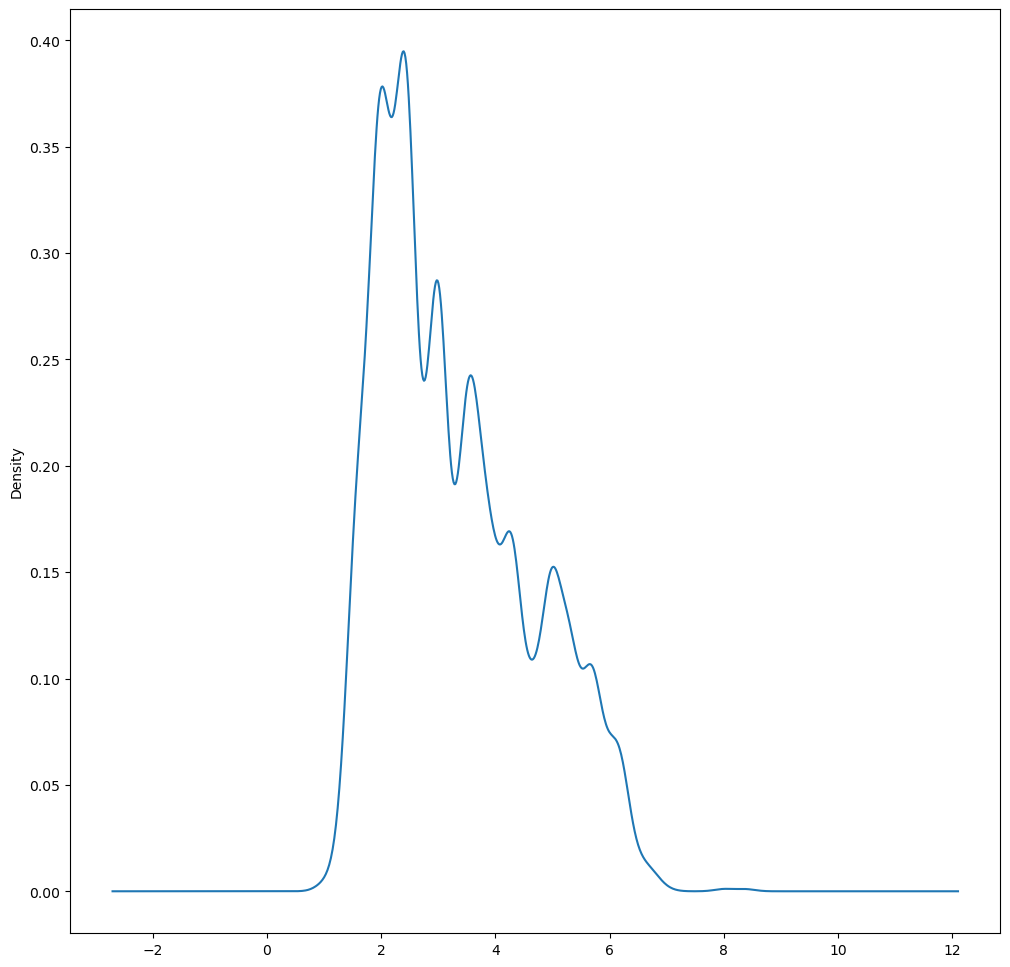

In [26]:
vehiculos.desplazamiento.plot.kde()

Vemos que la variable `desplazamiento` tiene un coeficiente de simetria claramente positivo con un peso mayor en la izquierda

In [27]:
from scipy import stats

In [28]:
stats.skew(vehiculos.desplazamiento)

0.6267820075196722

Hay dos técnicas principales para corregir estos dos tipos de problemas y mejorar nuestros modelos

**Normalización**

[Normalización](https://es.wikipedia.org/wiki/Normalizaci%C3%B3n_(estad%C3%ADstica)) (también llamada *min-max scaling*)

Normalización convierte una variable numérica con un rango cualquiera a un rango [0, 1]. Muchos modelos de `deep learning` exigen esto como requisito.

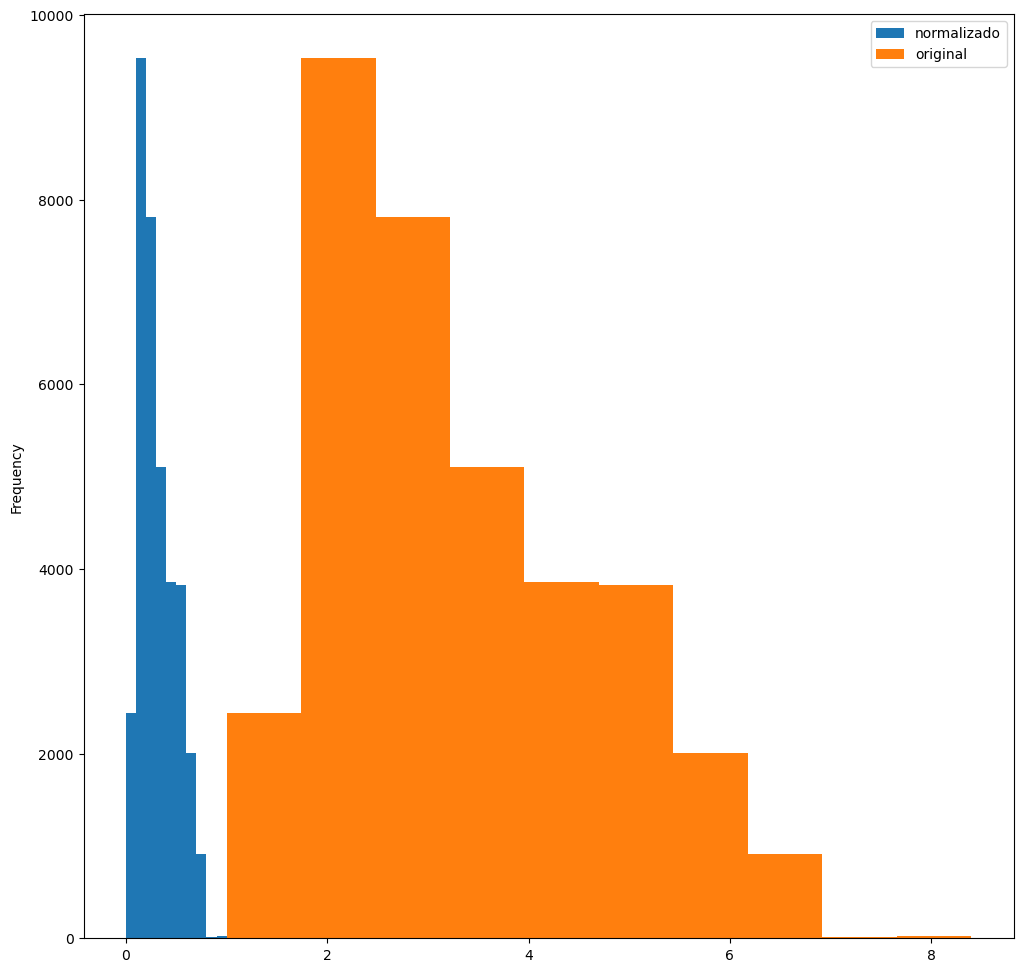

In [29]:
desplazamiento_x_min = vehiculos.desplazamiento.min()
desplazamiento_x_max = vehiculos.desplazamiento.max()

desplazamiento_original = vehiculos.desplazamiento
desplazamiento_normalizado = desplazamiento_original.apply(lambda x: (x-desplazamiento_x_min) / (desplazamiento_x_max - desplazamiento_x_min))

desplazamiento_normalizado.plot.hist(label="normalizado")
desplazamiento_original.plot.hist(label="original")
plt.legend();

**Estandarización**

El objetivo de la estandardización es reescalar la variable a una distribución con media 0 y desviación estándar 1.

Muchos algoritmos necesitan que todas las variables tengan una distribución normal. De hecho, [la librería principal](http://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) que vamos a usar para Machine Learning lo especifica en su documentación.

Estandarizar se puede realizar fácilmente convirtiendo cada valor a su puntuación Z, con la formula:

$$\frac{y-\mu}{\sigma}$$

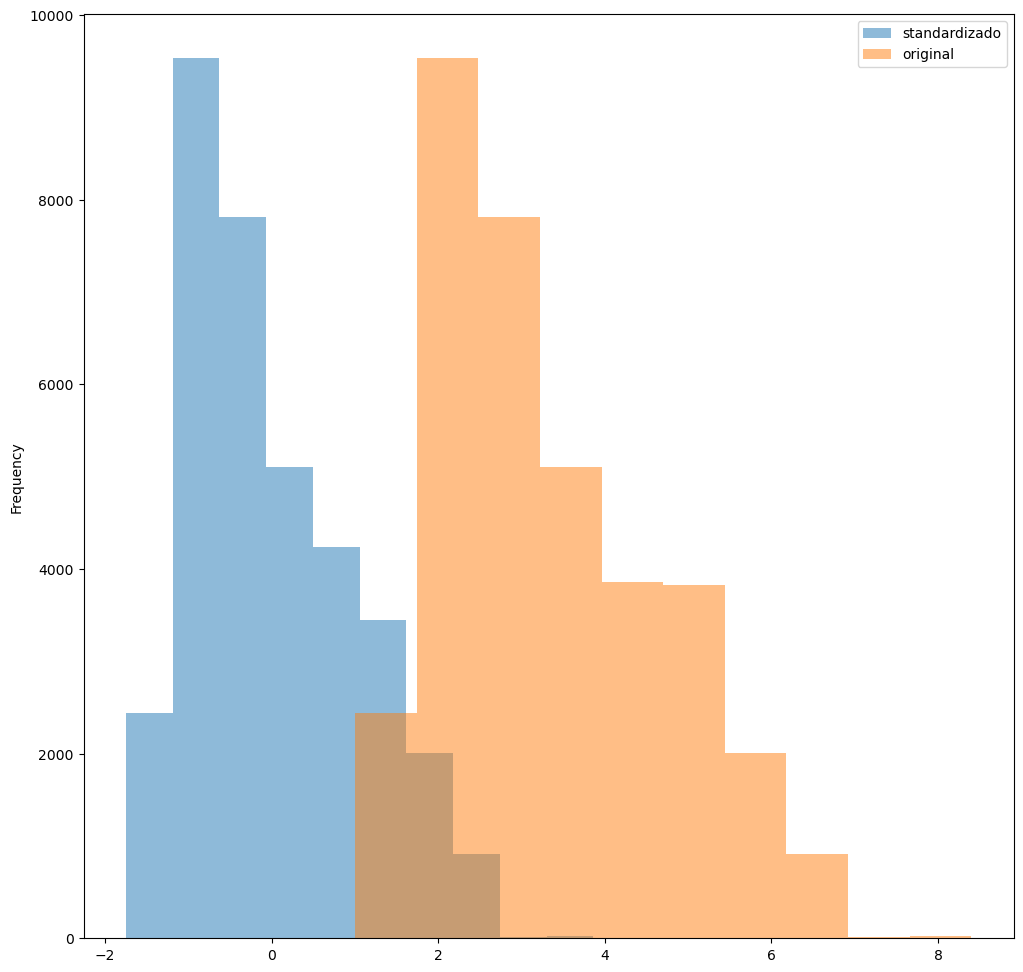

In [30]:
desplazamiento_mu = vehiculos.desplazamiento.mean()
desplazamiento_sigma = vehiculos.desplazamiento.std()

desplazamiento_estandarizado = desplazamiento_original.apply(lambda x: (x-desplazamiento_mu) / desplazamiento_sigma)

desplazamiento_estandarizado.plot.hist(label="standardizado", alpha=0.5)
desplazamiento_original.plot.hist(label="original", alpha=0.5)
plt.legend();

En cuanto a cuando elegir normalización o estandarización, esta decisión está sujeta a debate.

Si los algoritmos que se desea usar requieren una estructura de los datos concreta, entonces no hay que tomar una decisión, simplemente seguir los requisitos de dicho algoritmo.

Un problema que tiene la normalización es que la distancia absoluta entre los valores del dataset al agruparlos todos en un grupo tan pequeño. Por lo tanto si los datos varían mucho es mejor probar a estandarizar primero en vez de normalizar. No obstante no es mala idea el probar ambos procesos y ver cual da mejores resultados.

Por ejemplo, vamos a hacer un gráfico de dispersión para ver la comparación de las variables `displ` (desplazamiento del motor) y `comb08` (consumo de combustible) en funcion de si están normalizadas o estandarizadas.

In [31]:
consumo_original = vehiculos.consumo

consumo_mu = consumo_original.mean()
consumo_sigma = consumo_original.std()
consumo_min = consumo_original.min()
consumo_max = consumo_original.max()

consumo_estandarizado = consumo_original.apply(lambda x: (x-consumo_mu)/consumo_sigma)
consumo_normalizado = consumo_original.apply(lambda x: (x-consumo_min)/(consumo_max - consumo_min))

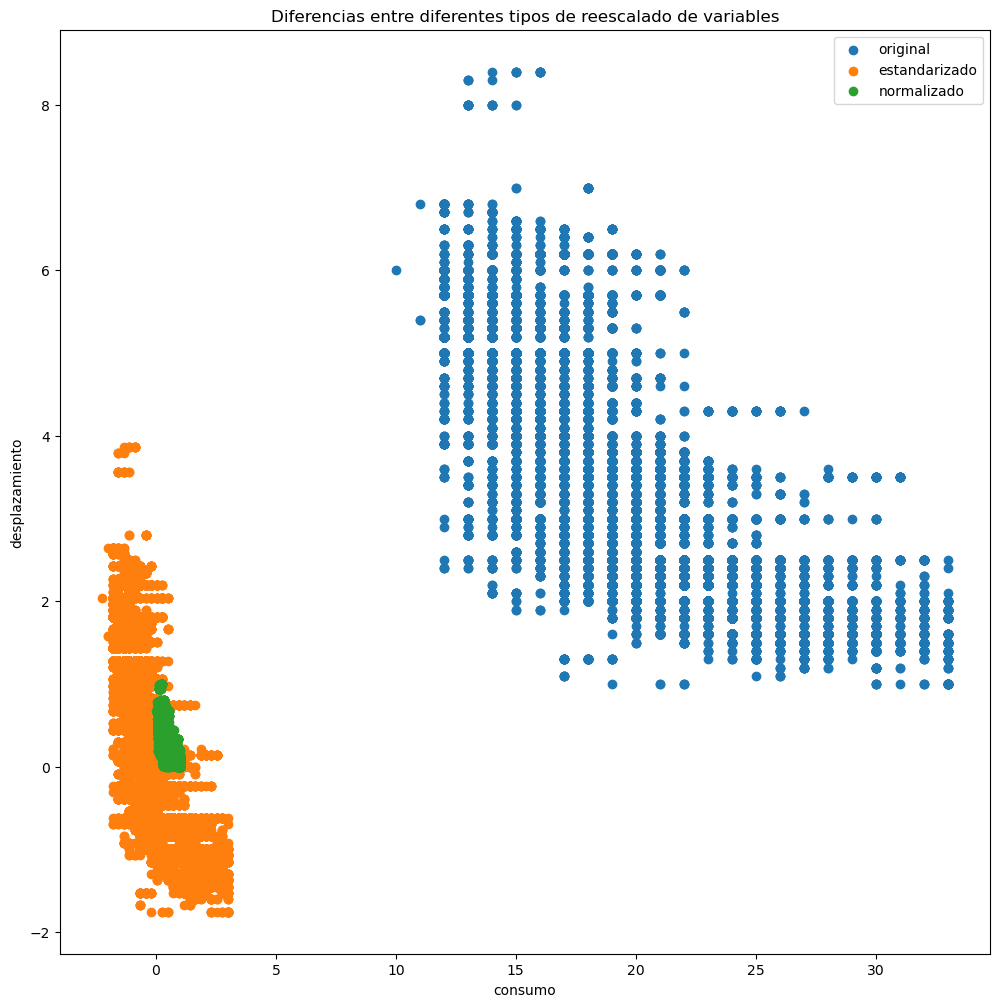

In [32]:
plt.scatter(x=consumo_original,y=desplazamiento_original, label="original")
plt.scatter(x=consumo_estandarizado,y=desplazamiento_estandarizado, label="estandarizado")
plt.scatter(x=consumo_normalizado,y=desplazamiento_normalizado, label="normalizado")

plt.xlabel("consumo")
plt.ylabel("desplazamiento")
plt.title("Diferencias entre diferentes tipos de reescalado de variables")
plt.legend();

Vemos que cuando las variables están estandarizadas, pese a que su rango es menor (entre -3 y 3 aproximadamente) vemos que reflejan mejor la relación entre ambas variables (incluyendo el outlier en comb08).

Cuando las variables estan normalizadas al estar "encajonadas" en el intervalo [0,1] cuesta más ver su relación cuando se comparan con la distribucion original.

Esto no implica que dicha relación de la distribución se altere, simplemente que los valores que separan los elementos de la variable se ven reducidos. Esto altera como ciertos métodos de aprendizaje alcanzan soluciones óptimas

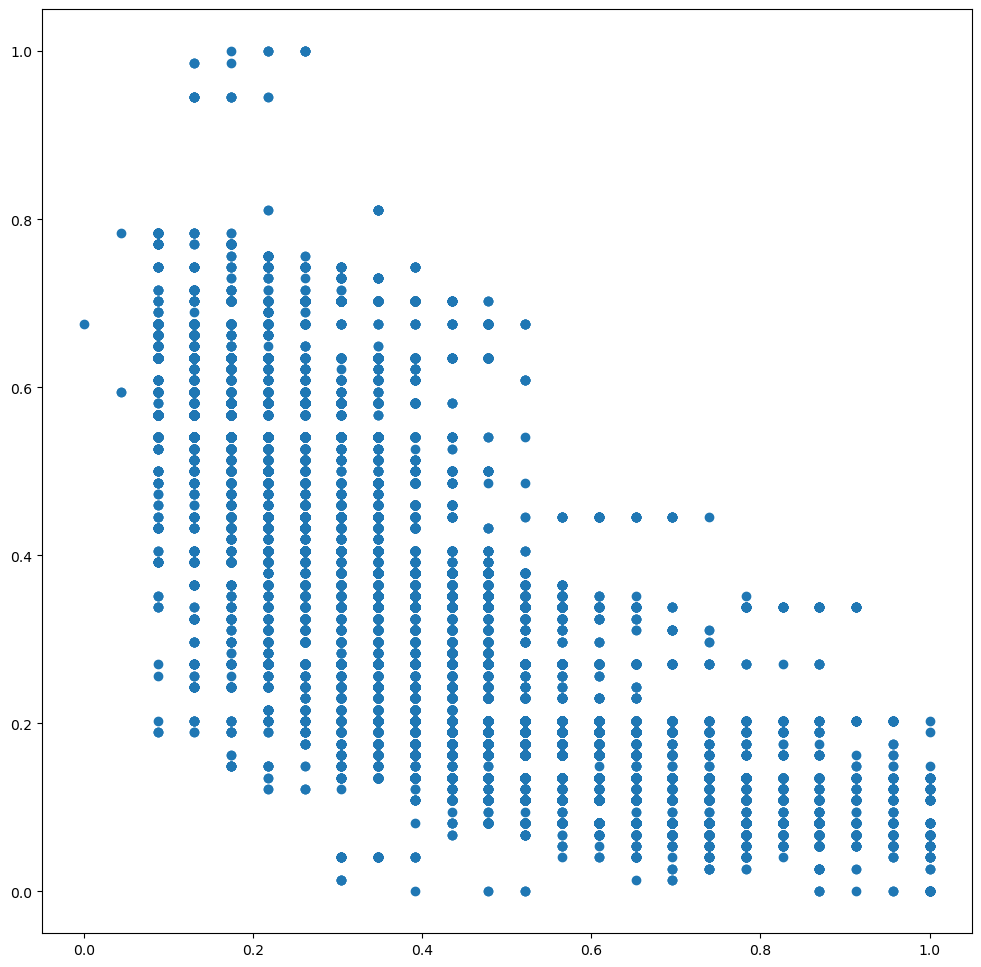

In [33]:
plt.scatter(x=consumo_normalizado,y=desplazamiento_normalizado, label="normalizado");

En este caso decidimos asignar dos columnas nuevas como las variables estandarizadas

In [34]:
vehiculos["consumo_std"] = consumo_estandarizado
vehiculos["desplazamiento_std"] = desplazamiento_estandarizado

In [35]:
vehiculos.head()

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,consumo_std,desplazamiento_std
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,-0.653195,-0.613385
2,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,-1.565710,0.676220
4,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500,-0.881324,-0.613385
5,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,-1.565710,0.676220
6,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,16,555.437500,-0.881324,0.372783


Finalmente, guardamos a csv el dataset limpio

In [36]:
vehiculos.to_csv("../data/vehiculos_procesado.csv", index=False)

### links

http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#about-standardization